This executable notebook will help you complete Pset 3.

If you haven't used Colab before, it's very similar to Jupyter / IPython / R Notebooks: cells containing Python code can be interactively run, and their outputs will be interpolated into this document. If you haven't used any such software before, we recommend [taking a quick tour of Colab](https://colab.research.google.com/notebooks/basic_features_overview.ipynb).

---

Now, a few Colab-specific things to note about execution before we get started:

- Google offers free compute (including GPU compute!) on this notebook, but *only for a limited time*. Your session will be automatically closed after 12 hours. That means you'll want to finish within 12 hours of starting, or make sure to save your intermediate work (see the next bullet).
- You can save and write files from this notebook, but they are *not guaranteed to persist*. For this reason, we'll mount a Google Drive account and write to that Drive when any files need to be kept permanently.
- You should keep this tab open until you're completely finished with the notebook. If you close the tab, your session will be marked as "Idle" and may be terminated.

# Getting started

**First**, make a copy of this notebook so you can make your own changes. Click *File -> Save a copy in Drive*.

### What you need to do

Read through this notebook and execute each cell in sequence, making modifications and adding code where necessary. You should execute all of the code as instructed, and make sure to write code or textual responses wherever the text **TODO** shows up in text and code cells.

When you're finished, choose *File -> Download .ipynb*. You will upload this `.ipynb` file as part of your submission.


## 1) Logistic Regression

### Background: logistic regression for binomial ordering preferences

We'll walk you through the example of logistic regression that we covered during class, where we took a dataset of binomial expressions and inferred the relative strengths of the short-before-long and frequent-before-infrequent ordering preferences.  We first load the dataset, which consists of a number of binomial expressions each of which was observed once in a sample of the Brown corpus, in the order given in the dataset.  In this dataset, `Syl` and `Freq` respectively denote whether the observed ordering matches the preference (an entry of `1`), violates the preference (an entry of `-1`), or is irrelevant for the preference (an entry of `0`, indicating that either ordering would satisfy the preference).  `Percept` indicates matching or violation of the perceptual markedness preference, and `Response` is a dummy variable whose value is always `1`, which we will use in fitting the logistic regression model.

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
d = pd.read_csv("https://gist.githubusercontent.com/scaperex/b577698c3f497f43df453d28c9c580fd/raw/6480ca2da71a42f75b490baa5387773f3aeb72e1/single_count_binomials.txt",header=0,sep=" ")
d

,Binomial,Percept,Syl,Freq,Response
1,abused and neglected,0,1,1,1
2,accept and hire,0,0,1,1
3,achieved and maintained,0,0,1,1
4,actively and continually,0,1,-1,1
5,adding and using,0,0,-1,1
...,...,...,...,...,...
326,wide and varied,0,1,1,1
327,wiry and fit,0,-1,-1,1
328,WordPerfect and Lotus,0,-1,-1,1
329,worried and troubled,0,0,1,1


Recall that logistic regression involves the following equations for predictors $\{X_i\}$:

$\eta = \sum_i \beta_i X_i$ (the **linear predictor**)

$P($outcome$=$success$) =\frac{e^{\eta}}{1 + e^{\eta}}$ (outcomes are Bernoulli distributed around the mean resulting from a logistic transformation of the linear predictor)

We have two predictors: $X_1$ is `Syl` and $X_2$ is `Freq`.  We use the `statsmodels` Python package to fit this logistic regression model to our dataset and infer the parameter weights $\{\beta_i\}$, which correspond to the preference strengths.  In `statsmodels`, as in most software packages implementing logistic regression, it is a convention that the numeric coding of the outcome or response is `1` for "success" and `0` otherwise.  Also as in most software packages for logistic regression, we use matrix formats to represent the response & predictors: so if there are $M$ predictors and $N$ observations, then the predictor set is represented as an $M \times N$ matrix and the response variable is represented as a $1 \times N$ matrix (effectively a length-$N$ vector).  We split our dataset into predictor and response matrices, and then fit a logistic regression model.

(In `statsmodels`, as with many statistical software packages, logistic regression is implemented as a special case of the more general framework of generalized linear models (GLMs), which is why the third line of the below cell looks the way it does.  We won't be covering GLMs in this class, but you may encounter them in other statistics classes or, perhaps less likely, in machine-learning classes.)

In [ ]:
x = d[["Syl","Freq"]]
y = d[["Response"]]
m = sm.GLM(y,x,family=sm.families.Binomial()) # first argument is response, second argument is predictor matrix, third argument says this is logistic regression
m_results = m.fit()
print(m_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                  330
Model:                            GLM   Df Residuals:                      328
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.95
Date:                Thu, 18 May 2023   Deviance:                       427.90
Time:                        13:21:50   Pearson chi2:                     330.
No. Iterations:                     4   Pseudo R-squ. (CS):             -2.657
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Syl            0.4825      0.154      3.131      0.0

The `coef` results of `0.48` for `Syl` and `0.40` match those we covered in class.

How well are we able to predict the ordering of a binomial we haven't previously seen will occur in?  To estimate this, we'll create a random 80/20 train/test split of our binomials data, estimate our logistic regression weights using the training dataset, and then see how often our prediction is successful ($P(success)>0.5$ for the observed ordering of the test-set binomial).  First we create our train/test split:

In [ ]:
import math, random
N = d.shape[0]
N_train = math.floor(N*4/5)
idx = list(range(N))
random.seed(3) # so that results will be reproducible from run to run
random.shuffle(idx)
idx_train = idx[0:N_train]
idx_test = idx[N_train:N]
print(idx_train)
print(idx_test)
d_train = d.iloc[idx_train]
d_test = d.iloc[idx_test]
print(d_train)

[272, 78, 13, 285, 211, 48, 188, 291, 292, 191, 244, 46, 233, 311, 139, 308, 70, 250, 287, 222, 192, 264, 54, 252, 163, 269, 180, 17, 238, 147, 38, 22, 220, 280, 41, 99, 239, 299, 288, 89, 135, 95, 146, 231, 42, 131, 312, 207, 224, 302, 138, 249, 289, 3, 274, 229, 142, 62, 12, 263, 171, 51, 124, 329, 165, 31, 120, 88, 226, 29, 304, 201, 36, 149, 58, 205, 122, 170, 127, 65, 102, 190, 0, 25, 230, 87, 206, 52, 169, 91, 97, 209, 182, 101, 59, 123, 193, 37, 268, 16, 254, 44, 144, 126, 293, 134, 105, 115, 130, 214, 200, 23, 73, 114, 107, 103, 40, 266, 159, 4, 166, 100, 28, 277, 283, 72, 113, 55, 325, 20, 43, 112, 57, 175, 82, 186, 24, 245, 261, 270, 61, 290, 56, 128, 232, 322, 265, 318, 204, 327, 177, 221, 275, 185, 47, 93, 260, 300, 228, 151, 76, 116, 219, 64, 94, 168, 178, 181, 294, 125, 237, 155, 173, 90, 314, 85, 160, 328, 321, 258, 161, 241, 262, 212, 5, 216, 148, 251, 2, 217, 140, 195, 257, 326, 284, 256, 234, 295, 184, 162, 110, 286, 235, 158, 26, 271, 174, 152, 164, 313, 133, 117, 21

And now we train a logistic model on only the training set, predict success probability for the observed binomials in the test set, and see how often we "succeed":

In [ ]:
x_train = d_train[["Syl","Freq"]]
y_train = d_train[["Response"]]
m = sm.GLM(y_train,x_train,family=sm.families.Binomial()) # first argument is response, second argument is predictor matrix, third argument says this is logistic regression
m_results = m.fit()
print(m_results.summary())
x_test = d_test[["Syl","Freq"]]
y_predicted = m_results.predict(x_test)
np.mean(y_predicted>0.5)


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                  264
Model:                            GLM   Df Residuals:                      262
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -170.38
Date:                Thu, 18 May 2023   Deviance:                       340.77
Time:                        13:21:54   Pearson chi2:                     264.
No. Iterations:                     4   Pseudo R-squ. (CS):             -2.636
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Syl            0.5005      0.171      2.931      0.0

0.6363636363636364

The answer: apparently somewhat better than 50/50 chance!

Another measure of how well a model fits a dataset is the log-likelihood it assigns to the data.  

In [ ]:
sum(np.log(y_predicted)) # large (less negative) values indicate better fit.

-43.59055060217463

### Accuracy and Log-likelihood

Note, in the binary classification case, accuracy is defined as:
$$Acc = \frac{1}{N} \sum_i  \mathbb{1}\{\hat{y_i}==y_i\}$$
Where

$$\hat{y_i} = 1 \ \textbf{if} \ \hat{p(x_i)}>0.5 \  \textbf{else} \ 0$$


And log likelihood is defined as:

$$L = \sum_i [y_i\cdot log(p(x_i)) + (1-y_i) \cdot log(1-p(x_i))] $$



### A new application of logistic regression: the dative alternation

The work you need to do for this pset involves applying logistic regression to a new case, the **dative alternation**, which we studied in a previous pset.  We will use the `dative` dataset from Bresnan et al. (2007).  First we load the dataset:

In [ ]:
dat = pd.read_csv("https://gist.githubusercontent.com/scaperex/278815a736401d36021aa9fe31b9a0cb/raw/cf338a8cf745fa5820c4ea97af682d265bc1a34f/dative-alternation.csv")
dat

,Unnamed: 0,Speaker,Modality,Verb,SemanticClass,LengthOfRecipient,AnimacyOfRec,DefinOfRec,PronomOfRec,LengthOfTheme,AnimacyOfTheme,DefinOfTheme,PronomOfTheme,RealizationOfRecipient,AccessOfRec,AccessOfTheme
0,1,NaN,written,feed,t,1,animate,definite,pronominal,14,inanimate,indefinite,nonpronominal,NP,given,new
1,2,NaN,written,give,a,2,animate,definite,nonpronominal,3,inanimate,indefinite,nonpronominal,NP,given,new
2,3,NaN,written,give,a,1,animate,definite,nonpronominal,13,inanimate,definite,nonpronominal,NP,given,new
3,4,NaN,written,give,a,1,animate,definite,pronominal,5,inanimate,indefinite,nonpronominal,NP,given,new
4,5,NaN,written,offer,c,2,animate,definite,nonpronominal,3,inanimate,definite,nonpronominal,NP,given,new
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,3258,S1190,spoken,tell,c,1,animate,definite,pronominal,1,inanimate,definite,pronominal,NP,given,given
3259,3259,S1423,spoken,give,a,1,animate,definite,pronominal,9,inanimate,indefinite,nonpronominal,NP,given,accessible
3260,3260,S1680,spoken,give,a,4,animate,indefinite,nonpronominal,2,inanimate,definite,nonpronominal,PP,accessible,accessible
3261,3261,S1680,spoken,give,a,1,inanimate,definite,pronominal,2,inanimate,indefinite,nonpronominal,NP,given,accessible


We see that it uses text values for some of the variables we are interested in (the response variable `RealizationOfRecipient`, and the variables expressing length and pronominality of theme and object).  We create numeric versions of these variables, arbitrarily coding a double object outcome as `1` ("success") and a prepositional dative outcome as `0`.

In [ ]:
dat["Response"] = [1 if x =="NP" else 0 for x in dat["RealizationOfRecipient"]]
dat["RecPro"] = [1 if x =="pronominal" else 0 for x in dat["PronomOfRec"]]
dat["ThemePro"] = [1 if x =="pronominal" else 0 for x in dat["PronomOfTheme"]]
dat[["RealizationOfRecipient","Response","PronomOfRec","RecPro","PronomOfTheme","ThemePro"]]

,RealizationOfRecipient,Response,PronomOfRec,RecPro,PronomOfTheme,ThemePro
0,NP,1,pronominal,1,nonpronominal,0
1,NP,1,nonpronominal,0,nonpronominal,0
2,NP,1,nonpronominal,0,nonpronominal,0
3,NP,1,pronominal,1,nonpronominal,0
4,NP,1,nonpronominal,0,nonpronominal,0
...,...,...,...,...,...,...
3258,NP,1,pronominal,1,pronominal,1
3259,NP,1,pronominal,1,nonpronominal,0
3260,PP,0,nonpronominal,0,nonpronominal,0
3261,NP,1,pronominal,1,nonpronominal,0


In [ ]:
## TODO: create numeric variables for PronomOfTheme
dat["logLengthOfTheme"]=np.log2(dat["LengthOfTheme"])
dat["logLengthOfRecipient"]=np.log2(dat["LengthOfRecipient"])

To capture the possibility of an overall preference for one construction or the other, we add an "intercept" term to the logistic regression model, by creating a new `Dummy` variable in the data frame.  We then fit a baseline model using only the intercept and find that there is an overall majority preference for the **DO** realization in this dataset (the intercept's fitted weight is greater than 0).  We also see that the intercept-only model simply recapitulates the sample mean.

In [ ]:
dat["Dummy"] = 1
x = dat[["Dummy"]]
y = dat[["Response"]]
m = sm.GLM(y,x,family=sm.families.Binomial()) # first argument is response, second argument is predictor matrix, third argument says this is logistic regression
m_results = m.fit()
print(m_results.summary())
print("Predicted proportion of DO outcomes based on fitted intercept-only model:", round(np.mean(m_results.predict(x)),4))
print("Proportion of data with DO outcome:", round(np.mean(y["Response"]),4)) # same as model-predicted proportion

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 3263
Model:                            GLM   Df Residuals:                     3262
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1870.5
Date:                Thu, 18 May 2023   Deviance:                       3741.1
Time:                        13:22:03   Pearson chi2:                 3.26e+03
No. Iterations:                     4   Pseudo R-squ. (CS):         -2.220e-16
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Dummy          1.0450      0.040     26.189      0.0

**Task:** In the below code boxes, complete the five parts of the problem specified in the pset PDF.

In [ ]:
## TODO: define and implement an 80/20 train/test random split of the "dative" dataset
#just like we did before
N = dat.shape[0]
N_train = math.floor(N*4/5)
idx = list(range(N))
random.seed(3)
random.shuffle(idx)
idx_train = idx[0:N_train]
idx_test = idx[N_train:N]
print(idx_train)
print(idx_test)
d_train = dat.iloc[idx_train]
d_test = dat.iloc[idx_test]
print(d_train)

[942, 2352, 2947, 2247, 2138, 990, 2484, 226, 2762, 476, 3122, 2996, 592, 1809, 1672, 1014, 3162, 480, 713, 2706, 2214, 1169, 76, 1244, 1586, 1610, 2900, 1534, 2037, 3193, 1622, 2326, 554, 597, 2467, 1090, 1890, 1461, 2986, 2957, 5, 1478, 1192, 2622, 107, 3025, 346, 1702, 2862, 2013, 375, 320, 1756, 1667, 3010, 281, 1281, 2932, 1895, 1448, 619, 1451, 463, 1959, 743, 374, 2348, 2021, 2213, 2350, 672, 2687, 52, 1171, 3024, 3175, 602, 1303, 1714, 229, 1682, 1561, 2647, 1314, 1038, 2621, 2184, 2809, 1679, 1370, 2045, 1036, 1658, 304, 3166, 3146, 2497, 473, 845, 938, 2486, 1458, 2613, 1491, 680, 870, 345, 92, 2191, 67, 2009, 2239, 1579, 501, 489, 1888, 755, 2260, 778, 828, 2182, 580, 567, 1466, 1360, 568, 1070, 1084, 897, 2361, 717, 2222, 1190, 472, 276, 3113, 2770, 1071, 670, 458, 2976, 3198, 1212, 1806, 779, 328, 2415, 647, 2733, 2340, 540, 2708, 1347, 2211, 1703, 3208, 917, 186, 2987, 1008, 178, 922, 2119, 130, 1273, 493, 1736, 2693, 1429, 2519, 2704, 1674, 2029, 389, 3012, 1495, 1908, 2

In [ ]:
def log_likelihood(predictions, labels):
    values = [y*np.log(predicted)+(1-y)*np.log(1-predicted) for y, predicted in zip(labels.values, predictions)]
    return sum(values)[0]

In [ ]:
def accuracy(predictions, labels):
    labelled_predictions = [1 if prediction > 0.5 else 0 for prediction in predictions]
    correct = [1 if prediction == label else 0 for prediction, label in zip(labelled_predictions, labels)]
    return sum(correct)/len(labels)

In [ ]:
## TODO: Fit a logistic regression model to the training set that uses only recipient pronominality
##       and an intercept term.
##       What is its classification accuracy on the held-out test dataset? How about its log-likelihood?
x_train = d_train[["RecPro","Dummy"]]
y_train = d_train[["Response"]]
m = sm.GLM(y_train,x_train,family=sm.families.Binomial())
m_results = m.fit()
print(m_results.summary())
x_test = d_test[["RecPro","Dummy"]]
y_test = d_test[["Response"]]
y_predicted = m_results.predict(x_test)
print("Predicted proportion of DO outcomes based on fitted intercept and recipient pronominality model:", round(np.mean(y_predicted), 4))
print("Proportion of data with DO outcome:", round(np.mean(dat["Response"]),4))
print(f'Classification Accuracy: {round(accuracy(y_predicted, y_test.values), 4)}')
print(f'Log-Likelihood {round(log_likelihood(y_predicted, y_test), 4)}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 2610
Model:                            GLM   Df Residuals:                     2608
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1231.6
Date:                Thu, 18 May 2023   Deviance:                       2463.2
Time:                        13:22:08   Pearson chi2:                 2.61e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1861
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RecPro         2.2048      0.103     21.490      0.0

**TODO:** interpretation goes here.

The findings suggest that the model's suitability is significant. The significantly low p-value and the coefficient of the variable both indicate that Recipient Pronominality is a reliable indicator for DO. Furthermore, the predicted proportion of DO outcomes (0.735) closely resembled the actual proportion (0.739), although this measure alone may not be highly informative. However, the classification accuracy ultimately reached only 0.61, surpassing random performance but not achieving exceptional results. Additionally, the log-likelihood yielded a considerably negative value, suggesting that the fit may not be as strong as initially anticipated.

In [ ]:
## TODO: Add theme pronominality as a predictor to the model and see whether that improves the
##       model’s predictive power as assessed by held-out classification accuracy and log-likelihood.
x_train = d_train[["RecPro","ThemePro","Dummy"]]
y_train = d_train[["Response"]]
m = sm.GLM(y_train,x_train,family=sm.families.Binomial())
m_results = m.fit()
print(m_results.summary())
x_test = d_test[["RecPro","ThemePro","Dummy"]]
y_test = d_test[["Response"]]
y_predicted = m_results.predict(x_test)
print("Predicted proportion of DO outcomes based on fitted intercept and recipient pronominality model:", round(np.mean(y_predicted), 4))
print("Proportion of data with DO outcome:", round(np.mean(dat["Response"]),4))
print(f'Classification Accuracy: {round(accuracy(y_predicted, y_test.values), 4)}')
print(f'Log-Likelihood {round(log_likelihood(y_predicted, y_test), 4)}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 2610
Model:                            GLM   Df Residuals:                     2607
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1040.9
Date:                Thu, 18 May 2023   Deviance:                       2081.7
Time:                        13:22:10   Pearson chi2:                 2.59e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2967
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RecPro         2.9470      0.139     21.169      0.0

**TODO:** interpretation goes here.

These results demonstrate a substantial improvement. The p-values once again affirm the significance of both variables in the regression model. Notably, the accuracy has shown a notable improvement, reaching 0.787, which is statistically significant. Moreover, the log-likelihood of this model has improved significantly, indicating a stronger fit. Based on these findings, we can confidently conclude that the Theme Pronominality variable plays a valuable role in enhancing the predictive power and fit of the model.

In [ ]:
## TODO: Determine whether additionally adding theme and recipient length (in number of words)
##       to the model further improves fit. Try both raw length or log-transformed length.
##       Which gives better performance?

In [ ]:
#Length
x_train = d_train[["RecPro", "ThemePro","LengthOfTheme","LengthOfRecipient","Dummy"]]
y_train = d_train[["Response"]]
m = sm.GLM(y_train,x_train,family=sm.families.Binomial())
m_results = m.fit()
print(m_results.summary())
x_test = d_test[["RecPro", "ThemePro","LengthOfTheme","LengthOfRecipient","Dummy"]]
y_test = d_test[["Response"]]
y_predicted = m_results.predict(x_test)
print("Predicted proportion of DO outcomes based on fitted intercept and recipient pronominality model:", round(np.mean(y_predicted), 4))
print("Proportion of data with DO outcome:", round(np.mean(dat["Response"]),4))
print(f'Classification Accuracy: {round(accuracy(y_predicted, y_test.values), 4)}')
print(f'Log-Likelihood {round(log_likelihood(y_predicted, y_test), 4)}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 2610
Model:                            GLM   Df Residuals:                     2605
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -877.43
Date:                Thu, 18 May 2023   Deviance:                       1754.9
Time:                        13:22:13   Pearson chi2:                 3.96e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3795
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
RecPro                2.6148      0.16

In [ ]:
#Log-transformed length
x_train = d_train[["RecPro", "ThemePro","logLengthOfTheme","logLengthOfRecipient","Dummy"]]
y_train = d_train[["Response"]]
m = sm.GLM(y_train,x_train,family=sm.families.Binomial())
m_results = m.fit()
print(m_results.summary())
x_test = d_test[["RecPro", "ThemePro","logLengthOfTheme","logLengthOfRecipient","Dummy"]]
y_test = d_test[["Response"]]
y_predicted = m_results.predict(x_test)
print("Predicted proportion of DO outcomes based on fitted intercept and recipient pronominality model:", round(np.mean(y_predicted), 4))
print("Proportion of data with DO outcome:", round(np.mean(dat["Response"]),4))
print(f'Classification Accuracy: {round(accuracy(y_predicted, y_test.values), 4)}')
print(f'Log-Likelihood {round(log_likelihood(y_predicted, y_test), 4)}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 2610
Model:                            GLM   Df Residuals:                     2605
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -878.94
Date:                Thu, 18 May 2023   Deviance:                       1757.9
Time:                        13:22:13   Pearson chi2:                 2.70e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3788
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
RecPro                   2.2690 

The inclusion of both the word length of the theme and recipient has further improved the model. Since the log-transformed lengths slightly outperformed the raw length, we will report the statistics based on these variables. The accuracy has significantly improved to an impressive 0.847, showcasing commendable predictive performance. Additionally, the log-likelihood has increased even further, indicating a substantial enhancement in predictive power and an improved fit. Overall, these covariates are deemed significant and contribute significantly to the model's overall performance.

As previously discussed, the coefficient values indicate that the original variables, recipient and theme pronominiality, hold significant importance in the model. The length variables, on the other hand, do not contribute as substantially. However, we learned in class about Panini's Law and its relationship to Ordering Preferences, where shorter words in terms of syllables tend to take precedence. Although this is not directly applicable to our specific case, there is a connection between word length and number of syllables (albeit imperfect). Intuitively, this connection makes sense, and exploring a model that incorporates this relationship would be intriguing.

Considering the high accuracy achieved without including the length variables, there is a possibility of overfitting. Moreover, incorporating length variables aligns with linguistic sensibility. Additionally, in our case, larger DO phrases are often reported as awkward, suggesting that length may influence the outcome. To integrate these variables into the model, we propose incorporating first-degree interactions between the variables. It is important to note that it would not make sense linguistically to add interactions between variables that pertain to different objects. Therefore, we will introduce the variables 'RecPro & LengthofRecipient' as well as 'ThemePro & LengthofTheme'. Furthermore, we will utilize log-transformed length rather than the raw length, as it yielded a better fit in our case.

In [ ]:
#Multiply by log-transformed length
dat['logMultRec'] = dat['RecPro']*dat['logLengthOfRecipient']
dat['logMultTheme'] = dat['ThemePro']*dat['logLengthOfTheme']
N = dat.shape[0]
N_train = math.floor(N*4/5)
idx = list(range(N))
random.seed(3)
random.shuffle(idx)
idx_train = idx[0:N_train]
idx_test = idx[N_train:N]
d_train = dat.iloc[idx_train]
d_test = dat.iloc[idx_test]

In [ ]:
x_train = d_train[["logMultRec", "logMultTheme","Dummy"]]
y_train = d_train[["Response"]]
m = sm.GLM(y_train,x_train,family=sm.families.Binomial())
m_results = m.fit()
print(m_results.summary())
x_test = d_test[["logMultRec", "logMultTheme","Dummy"]]
y_test = d_test[["Response"]]
y_predicted = m_results.predict(x_test)
print("Predicted proportion of DO outcomes based on fitted intercept and recipient pronominality model:", round(np.mean(y_predicted), 4))
print("Proportion of data with DO outcome:", round(np.mean(dat["Response"]),4))
print(f'Classification Accuracy: {round(accuracy(y_predicted, y_test.values), 4)}')
print(f'Log-Likelihood {round(log_likelihood(y_predicted, y_test), 4)}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 2610
Model:                            GLM   Df Residuals:                     2607
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1486.4
Date:                Thu, 18 May 2023   Deviance:                       2972.9
Time:                        13:22:18   Pearson chi2:                 2.61e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01054
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
logMultRec      -0.7854      0.214     -3.673   

Given the significant loss of accuracy and goodness of fit observed, it is prudent to explore alternative approaches. Therefore, we will now consider interactions between the two 'Pronominality' variables and the two 'length' variables. This adjustment aims to capture potential synergistic effects between these variables and potentially improve the model's performance.

In [ ]:
#Interactions between the two 'Pronominality' variables and the two 'length' variables
dat['MultRecTheme'] = dat['RecPro']*dat['ThemePro']
dat['MultLength'] = dat['logLengthOfRecipient']*dat['logLengthOfTheme']
N = dat.shape[0]
N_train = math.floor(N*4/5)
idx = list(range(N))
random.seed(3)
random.shuffle(idx)
idx_train = idx[0:N_train]
idx_test = idx[N_train:N]
d_train = dat.iloc[idx_train]
d_test = dat.iloc[idx_test]

In [ ]:
x_train = d_train[["MultRecTheme", "MultLength","Dummy"]]
y_train = d_train[["Response"]]
m = sm.GLM(y_train,x_train,family=sm.families.Binomial())
m_results = m.fit()
print(m_results.summary())
x_test = d_test[["MultRecTheme", "MultLength","Dummy"]]
y_test = d_test[["Response"]]
y_predicted = m_results.predict(x_test)
print("Predicted proportion of DO outcomes based on fitted intercept and recipient pronominality model:", round(np.mean(y_predicted), 4))
print("Proportion of data with DO outcome:", round(np.mean(dat["Response"]),4))
print(f'Classification Accuracy: {round(accuracy(y_predicted, y_test.values), 4)}')
print(f'Log-Likelihood {round(log_likelihood(y_predicted, y_test), 4)}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 2610
Model:                            GLM   Df Residuals:                     2607
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1369.8
Date:                Thu, 18 May 2023   Deviance:                       2739.7
Time:                        13:22:20   Pearson chi2:                 2.59e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09512
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
MultRecTheme    -1.6340      0.146    -11.179   

These results are truly impressive. We have achieved a slight improvement in both accuracy and model fit by enhancing the log-likelihood. Moreover, we have accomplished this while reducing the number of variables to only two. This approach, which involves breaking down our variables into separate components representing length and pronominality, is not only statistically beneficial but also linguistically logical. By adopting this approach, we have successfully maintained the essence of the original model while simultaneously enhancing efficiency.

In summary, we have successfully constructed a model that exhibits improved fit and linguistic soundness without sacrificing much accuracy. This was achieved by incorporating first-degree interactions between the relevant variables. By doing so, we have enhanced the model's performance and captured the intricate relationships between the variables more effectively.

##2) Word embeddings

The below code and text are for the second problem on the pset.  Note that the second code chunk will take several minutes to run, but only needs to be run once, which will download the GLoVe vectors and save them on your Google drive in a new folder named *096222-pset-3* (about 1GB for the glove.6B.zip dataset). When done with the pset you may delete the files to free up space.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_DIR = "/content/gdrive/My Drive/096222-pset-3"

Mounted at /content/gdrive


In [ ]:
# This code chunk needs to be run only the first time through the pset.
# It downloads the GLoVe word embeddings and saves them to your Google drive.
!time wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!mkdir -p "$GDRIVE_DIR"
!mv glove.6B.300d.txt "$GDRIVE_DIR/"

--2023-05-18 13:22:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-18 13:22:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-18 13:22:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import sys
import numpy

def read_vectors_from_file(filename):
    d = {}
    with open(filename, 'rt') as infile:
        for line in infile:
            word, *rest = line.split()
            d[word] = numpy.array(list(map(float, rest)))
    return d

e = read_vectors_from_file(GDRIVE_DIR + "/glove.6B.300d.txt")

In [ ]:
e['apples']

array([-0.17994  ,  0.076623 ,  0.15722  , -0.22001  , -0.018468 ,
       -0.23543  ,  0.066769 ,  0.31273  ,  0.13766  , -0.10719  ,
        0.042323 , -0.22365  ,  0.15889  , -0.13794  ,  0.018843 ,
        0.26975  , -0.53504  , -0.54033  ,  0.013745 ,  0.27357  ,
       -0.37072  ,  0.25398  ,  0.25217  ,  0.20234  ,  0.031093 ,
       -0.55085  , -0.93268  , -0.064355 ,  0.073996 , -0.28748  ,
       -0.73238  ,  0.038759 , -0.23089  , -0.35184  , -0.40089  ,
        0.15194  ,  0.083998 ,  0.3137   , -0.80714  , -0.4338   ,
        0.66056  , -0.28821  , -0.11314  , -0.0079687,  0.28257  ,
       -0.047495 , -0.63175  ,  0.29189  ,  0.0064372,  0.57836  ,
       -0.053689 , -0.31578  , -0.078192 , -0.39074  , -1.0015   ,
       -0.65737  , -0.30738  , -0.26731  , -0.18491  ,  0.067175 ,
        0.14621  , -0.013356 , -0.18675  ,  0.28284  , -0.18525  ,
       -0.075742 , -0.16288  ,  0.12174  , -0.54502  ,  0.10662  ,
        0.086968 , -0.04665  , -0.20161  ,  0.053088 , -1.0036

### Implement and test the cosine measure of word similarity.

In [ ]:
import numpy as np

In [ ]:
## Write a function to compute the cosine similarity between two word vectors.
##       Demonstrate that it's symmetric with a few examples.
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    dot_product = np.dot (x,y)
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y)
    res = dot_product/ (x_norm* y_norm)
    return res

def verify(x):
  if x: print("Verified")
  else: print("Failure to verify")

## Use some examples to demonstrate symmetry of your implementation.
verify(cosine_similarity(e['apples'],e['oranges'])==cosine_similarity(e['oranges'],e['apples']))

## TODO: add a few more examples here.
verify(cosine_similarity(e['car'],e['truck'])==cosine_similarity(e['truck'],e['car']))
verify(cosine_similarity(e['mars'],e['venus'])==cosine_similarity(e['venus'],e['mars']))
verify(cosine_similarity(e['warm'],e['cool'])==cosine_similarity(e['cool'],e['warm']))
verify(cosine_similarity(e['red'],e['blue'])==cosine_similarity(e['blue'],e['red']))

Verified
Verified
Verified
Verified
Verified


In [ ]:
## Verify the sanity checks in part 1b of the pset PDF.
verify(cosine_similarity(e['car'],e['truck']) > cosine_similarity(e['car'],e['person']))
verify(cosine_similarity(e['mars'],e['venus']) > cosine_similarity(e['mars'],e['goes'])) # TODO Convert Mars and Venus to lowercase
verify(cosine_similarity(e['warm'],e['cool']) > cosine_similarity(e['warm'],e['yesterday']))
verify(cosine_similarity(e['red'],e['blue']) > cosine_similarity(e['red'],e['fast']))


Verified
Verified
Verified
Verified


In [ ]:
## TODO: come up with two examples that demonstrate correct similarity relations.
verify(cosine_similarity(e['lion'],e['tiger']) > cosine_similarity(e['lion'],e['car']))
verify(cosine_similarity(e['small'],e['big']) > cosine_similarity(e['small'],e['mars']))

Verified
Verified


In [ ]:
## TODO: come up with two examples where cosine similarity doesn't align with your intuitions about word similarity.
verify(cosine_similarity(e['lion'],e['cat']) > cosine_similarity(e['lion'],e['dog']))
verify(cosine_similarity(e['car'],e['driver']) > cosine_similarity(e['car'],e['truck']))

Failure to verify
Failure to verify


{lion, cat} vs. {lion, dog}:
We believe that "lion" is generally associated with the feline family and therefore would be more strongly associated with "cat", while "dog" is generally associated with animals, a concept that encompasses a wider range of species than just cats.

{car, driver} vs. {car, truck}:
During our comparison of "car" and "driver" versus "car" and "truck," we noted that both pairs are associated with transportation and driving. However, they represent distinct entities and concepts within that domain. "Car" and "truck" are both tangible objects used for transportation, while "driver" represents a concept related to the individual operating the vehicle. This distinction could potentially explain why "car" was found to be more similar to "truck" than to "driver."



In [ ]:
## TODO: extra credit goes here if you want to do it.
def euclidean_distance(x: np.ndarray, y: np.ndarray):
  sqrt = np.square(x - y)
  sum = np.sum(sqrt)
  res = np.sqrt(sum)
  return res

In [ ]:
#Comparing of the same pair of words of the cosine similarity
verify(euclidean_distance(e['apples'],e['oranges'])==euclidean_distance(e['oranges'],e['apples']))
verify(euclidean_distance(e['car'],e['truck']) > euclidean_distance(e['car'],e['person']))
verify(euclidean_distance(e['mars'],e['venus']) > euclidean_distance(e['mars'],e['goes']))
verify(euclidean_distance(e['warm'],e['cool']) > euclidean_distance(e['warm'],e['yesterday']))
verify(euclidean_distance(e['red'],e['blue']) > euclidean_distance(e['red'],e['fast']))

Verified
Failure to verify
Failure to verify
Failure to verify
Failure to verify


In [ ]:
## TODO: come up with two examples that demonstrate correct similarity relations.
#The same test
verify(euclidean_distance(e['lion'],e['tiger']) > euclidean_distance(e['lion'],e['car']))
verify(euclidean_distance(e['small'],e['big']) > euclidean_distance(e['small'],e['mars']))

Failure to verify
Failure to verify


In [ ]:
## TODO: come up with two examples where cosine similarity doesn't align with your intuitions about word similarity.
#The same test
verify(euclidean_distance(e['lion'],e['cat']) > euclidean_distance(e['lion'],e['dog']))
verify(euclidean_distance(e['car'],e['driver']) > euclidean_distance(e['car'],e['truck']))

Verified
Verified


Our observation revealed that for every "Verified" pair of similarity scores calculated using cosine similarity, we encountered "Failure to verify" pairs when employing Euclidean distance, and vice versa. This discrepancy can be attributed to the fundamental distinction in how these two metrics capture similarities between vectors. Cosine similarity focuses on measuring the similarity in direction or orientation of two vectors, while Euclidean distance considers both the similarity in magnitude and direction of the difference between them. Consequently, vectors with similar orientations but different magnitudes may be deemed similar by cosine similarity but dissimilar by Euclidean distance, resulting in contrasting similarity outcomes.

### The analogies task

Given words *w1*, *w2*, and *w3*, find a word *x* such that *w1* : *w2* :: *w3* : *x*. For example, for the analogy problem *France*:*Paris* :: *England*:*x*, the answer should be *London*. To solve analogies using semantic vectors, letting $e(w)$ indicate the embedding for a word w, calculate a vector $y$ = $e(w_2)$ − $e(w_1)$ + $e(w_3)$ and find the word whose vector is closest to $y$.

**TODO:** Explain why the analogy-solving method makes sense.



The analogy-solving method is logical because it utilizes word embeddings that are based on the inherent semantic relationships encoded within word vectors. Word embeddings assign words to high-dimensional vectors in a semantic space, where words with similar meanings are situated closer to each other compared to words with dissimilar meanings. These spatial relationships between vectors effectively capture the semantic connections between words.

By computing a vector that encapsulates the semantic relationship between two given words in an analogy, we can utilize this vector to predict an unknown word that shares a similar relationship to the third word. This prediction is accomplished by identifying the word whose vector is closest to the computed vector, utilizing a distance metric such as cosine similarity or Euclidean distance.

In [ ]:
## Write a function to calculate y as described above.
def analogy_vector(w1: str, w2: str, w3: str, e: dict) -> np.ndarray: # note that the function takes the word embedding dictionary as input.
  y = e[w2]- e[w1] + e[w3]
  return y

In [ ]:
## Write a function to find the k nearest neighbors to y.
def analogy(w1: str, w2: str, w3: str, e: dict, k=5):
  y= analogy_vector(w1, w2, w3, e)
  nn= {} #nearest neighbors
  top_keys = []

  for word in e:
     nn[word] = cosine_similarity(y, e[word])
  nn = dict(sorted(nn.items(), key=lambda item: item[1], reverse= True))

  for i, key in enumerate(nn.keys()):
    if key!= w3:
      top_keys.append(key)
    if i == k:
        break

  return top_keys

In [ ]:
## Are the top 5 results for the following analogies sensible?
print(analogy("france","paris","england",e))
print(analogy("man","woman","king",e))
print(analogy("tall","taller","warm",e))
print(analogy("tall","short","england",e))



['london', 'manchester', 'birmingham', 'middlesex', 'liverpool']
['queen', 'monarch', 'throne', 'princess', 'mother']
['warmer', 'warmed', 'cooler', 'drier', 'colder']
['short', 'following', 'wales', 'ireland', 'britain']



It's good to see that most of the results make sense. Regarding the fourth analogy, it seems like the model may be struggling with finding an appropriate analogy since there isn't really an opposite of a county. It's possible that the model is picking up on other associations with the word "county", such as location or population size, which might explain why words like "city" and "following" are appearing in the results. Nonetheless, it's interesting to see how the model is attempting to find a relationship between the given words.

Let's analyze each analogy individually:

In the first analogy, "London" being the closest word to the vector "y" is as we anticipated. Additionally, all the other four words being cities is in line with our understanding.

Moving to the second analogy, "queen" being the closest word to the vector "y" is the correct analogy. We can observe that the other four words are related either to strong women or to monarchy, which is conceptually relevant.

In the third analogy, "warmer" being the closest word to the vector "y" indicates that the algorithm successfully recognizes similar semantic contexts. The presence of other words related to "cold" and "warm" is logical given the given words and context.

For the fourth analogy, the absence of an exact analogy is understandable since "tall" and "short" are antonyms, and there is no direct opposite for a county. Consequently, the appearance of other cities and the word "short" in the results can be considered reasonable. However, it is unclear why the word "following" is one of the closest words, as it has a different meaning.

Overall, while most of the results align with our expectations and make sense, there may be instances where further examination is needed to understand the associations made by the algorithm.

In [ ]:
## TODO: come up with 4 more analogies, 2 of which work in your opinion, and 2 of which don't work.

#Some of the examples were taken from Psychometric exams, for the sport :)

#analogies which we believe work
print(analogy("mother","father","girl",e))
print(analogy("small","smaller","big",e))

#analogies which we believe won't work
print(analogy("house","person","kennel",e))
print(analogy("drink","water","play",e))

['boy', 'boys', 'father', 'son', 'man']
['bigger', 'smaller', 'larger', 'biggest', 'much']
['akc', 'person', 'purebred', 'breed', 'ukc']
['water', 'playing', 'played', 'plays', 'game']


**TODO:**
Did you notice any patterns or generalizations while exploring possible analogies? For the ones that went wrong, why do you think they went wrong?


We agree that obtaining accurate results in analogies often requires precise alignment between the words. The presence of plural, comparative, and superlative forms of words can pose challenges for the algorithm to accurately predict appropriate contexts and analogies.

Let's examine the examples provided:

1) Paris is the **capital** of France, just as London is the **capital** of England.

2) "smaller" is the comparative form of the adjective "small", just like "big" and "bigger". Similar to the given example of "tall":"taller" :: "hot": "warmer".
We can see that the algorithm is capable of these words correctly.

3) "mother" and "father" are identified as male and female, just as "girl" and "boy" are identified as male and female.

For the examples that didn't work, the relationship between the words is a bit more complex:

1) A house is a **living place for humans**, while a kennel is a **living place for dogs**. We believe that the complication in understanding the context detracts from the algorithm's ability to understand the intent. That is, if the context is not direct, or alternatively does not point directly to the reason for the context - the algorithm will not be accurate.

2) We believed that since the act of drinking is related to **water**, the act of playing would be related to **game** and we would get the correct analogy. However, the best word we got was "water". In addition, the results also include variations of "play", which supports our previous conclusion. We believe that the analogy is also a bit complicated because you don't just drink water, and there are other things that can be played, and not just a game.

Indeed, complex analogies can pose challenges for the algorithm, even if they appear logical and structured to human thinking. While the algorithm excels at capturing certain linguistic patterns and relationships, it may struggle with more intricate contexts that require deeper understanding or contextual knowledge.

Analogical reasoning often relies on the ability to identify subtle similarities and abstract relationships between words. Human thinking is influenced by various factors, including background knowledge, cultural context, and personal experiences, which allow us to make connections that may not be apparent solely from word embeddings.

The algorithm's performance is limited to the information it has been trained on and the patterns it has learned from the data. It may struggle to grasp the intricacies of certain analogies that require additional contextual understanding beyond the surface-level associations present in the word embeddings.

While the algorithm may fall short in complex scenarios, it is important to acknowledge its capabilities in recognizing more straightforward analogies and capturing certain linguistic patterns accurately. Continued research and advancements in natural language processing aim to improve the algorithms' ability to handle more complex analogies and align them more closely with human reasoning.

##3) Using semantic vectors to decode brain activation

### Load the data

In [ ]:
# Download and extract the data and learn_decoder.py
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

--2023-05-18 13:27:55--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 173.194.216.138, 173.194.216.101, 173.194.216.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/janafki8jmn11lu8n5jn9gl7036ke57f/1684416450000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=90d1a410-49ea-4d09-90de-98bba2bd91a8 [following]
--2023-05-18 13:27:55--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/janafki8jmn11lu8n5jn9gl7036ke57f/1684416450000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=90d1a410-49ea-4d09-90de-98bba2bd91a8
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 173.194.217.

In [ ]:
#Let's load the functions from learn_decoder.py
from learn_decoder import *

#and the data
data = read_matrix("imaging_data.csv", sep=",")
vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

You can verify for your self what learn_decoder consists of by going to Files and opening it.

### What are the Accuracy scores?

Define a function that computes rank-based accuracy score, then, iterate over the 18 folds. For each fold,  train the decoder **using the `learn_decoder` function** (the function is already imported from `learn_decoder.py`) on the fold train data, obtain the predicions on the fold test data, and store both the accuracy score of each concept (use the labels from `concepts`) as well as the average score of the 10 concepts.  

In [ ]:
#calculate the rank of the true vector based on cosine similarity
def rank_based_accuracy (decoded_vec, true_vec):
  rank= {}
  true_vec_index = -1

  for i in range(vectors.shape[0]):
    rank[i]= cosine_similarity(vectors[i], decoded_vec)
    if np.array_equal(true_vec, vectors[i]):
      true_vec_index=i

  rankings = dict(sorted(rank.items(), key=lambda item: item[1], reverse= True))
  final_rank = list(rankings).index(true_vec_index)

  return final_rank+1


In [ ]:
all_ranks = {} #rank of each concept
avg_ranking = {} #avg rank of each fold

def calculate_rank(decoder_res, test_set, test_vectors, index):
  key= (index/10)+1
  test_fold_ranking= []
  for i in np.arange(test_set.shape[0]):
    dot_prod = np.dot(test_set[i],decoder_res) #semantic vector - the model's best guess to the concept
    current_rank= rank_based_accuracy(dot_prod, test_vectors[i]) #rank of the current test data
    test_fold_ranking.append(current_rank)
    all_ranks[concepts[index]]= current_rank
    index= index+1

  avg_ranking[key]= sum(test_fold_ranking)/len(test_fold_ranking)

In [ ]:
#iterate each fold and split to train set and test set

for i in np.arange(0, data.shape[0], 10):
  temp_test_set= data[i:i+10]
  temp_test_vectors= vectors[i:i+10]

  if i ==0:
    temp_train_set = data[i+10:data.shape[0]]
    temp_train_vectors= vectors[i+10:data.shape[0]]
  elif i== 170:
    temp_train_set= data[0: data.shape[0]-10]
    temp_train_vectors= vectors[0: data.shape[0]-10]
  else :
    temp_train_set= np.concatenate((data[0:i], data[i+10: data.shape[0]]))
    temp_train_vectors= np.concatenate((vectors[0:i], vectors[i+10: data.shape[0]]))

  decoder_res= learn_decoder(temp_train_set, temp_train_vectors) #decoder matrix

  calculate_rank(decoder_res, temp_test_set, temp_test_vectors, i) #calculate rank for each concpet and for each fold

  print(f'average score of fold num {(i/10)+1} is: {avg_ranking[(i/10)+1]}')

average score of fold num 1.0 is: 66.7
average score of fold num 2.0 is: 62.3
average score of fold num 3.0 is: 60.4
average score of fold num 4.0 is: 70.6
average score of fold num 5.0 is: 81.3
average score of fold num 6.0 is: 74.5
average score of fold num 7.0 is: 77.0
average score of fold num 8.0 is: 46.7
average score of fold num 9.0 is: 105.1
average score of fold num 10.0 is: 39.1
average score of fold num 11.0 is: 65.6
average score of fold num 12.0 is: 56.5
average score of fold num 13.0 is: 36.9
average score of fold num 14.0 is: 66.0
average score of fold num 15.0 is: 41.7
average score of fold num 16.0 is: 36.8
average score of fold num 17.0 is: 39.7
average score of fold num 18.0 is: 87.5


Now let's plot the averaged accuracy score for each fold  

Text(0, 0.5, 'Avg Accuracy Score')

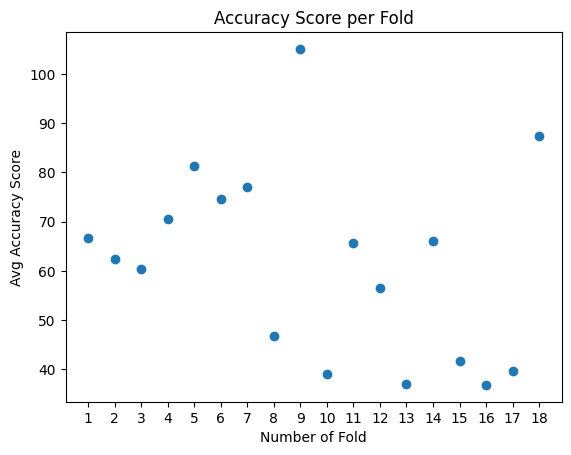

In [ ]:
import matplotlib.pyplot as plt

x_axis =np.arange(1,19)
y_axis = avg_ranking.values()
plt.scatter(x_axis, y_axis)
x_tick = plt.xticks(range(min(x_axis), max(x_axis)+1))
plt.title("Accuracy Score per Fold")
plt.xlabel("Number of Fold")
plt.ylabel("Avg Accuracy Score")

### Which concepts can be decoded with more or less success?

We'll consider a "successful concept"  as a concept with an average rank lower than 90, as a score of 90 represents random noise.

In [ ]:
successful_concepts = {}
failed_concepts = {}

for concept in concepts:
  if all_ranks[concept]<90:
    successful_concepts[concept]= all_ranks[concept]
  else:
    failed_concepts[concept]= all_ranks[concept]

successful_concepts = dict(sorted(successful_concepts.items(), key=lambda item: item[1]))
failed_concepts = dict(sorted(failed_concepts.items(), key=lambda item: item[1] ,  reverse= True))

In [ ]:
print(f'successful concepts are : {successful_concepts}')

successful concepts are : {'do': 1, 'food': 1, 'time': 1, 'great': 2, 'laugh': 4, 'stupid': 5, 'lady': 6, 'left': 6, 'hair': 7, 'money': 7, 'ability': 8, 'big': 8, 'play': 8, 'relationship': 8, 'crazy': 9, 'music': 9, 'picture': 9, 'building': 10, 'construction': 10, 'feeling': 10, 'extremely': 11, 'dinner': 12, 'silly': 12, 'help': 13, 'light': 13, 'wear': 13, 'word': 13, 'read': 14, 'shape': 14, 'show': 14, 'soul': 14, 'damage': 15, 'fish': 15, 'skin': 15, 'successful': 15, 'team': 15, 'event': 16, 'quality': 16, 'art': 17, 'attitude': 17, 'mountain': 17, 'road': 18, 'dog': 19, 'unaware': 20, 'poor': 21, 'taste': 21, 'tried': 21, 'angry': 22, 'pain': 22, 'business': 24, 'plan': 25, 'science': 25, 'war': 25, 'student': 28, 'body': 29, 'sign': 29, 'broken': 31, 'pleasure': 31, 'tree': 31, 'carefully': 32, 'star': 33, 'economy': 34, 'level': 35, 'movement': 35, 'smiling': 35, 'solution': 35, 'election': 36, 'typical': 36, 'useless': 36, 'challenge': 37, 'law': 37, 'sound': 37, 'tool': 3

In [ ]:
print(f'failed concepts are : {failed_concepts}')

failed concepts are : {'argumentatively': 180, 'cockroach': 178, 'applause': 175, 'deceive': 171, 'electron': 168, 'dissolve': 164, 'movie': 159, 'elegance': 158, 'usable': 158, 'sew': 157, 'sin': 152, 'mathematical': 150, 'vacation': 150, 'ignorance': 146, 'emotionally': 145, 'kindness': 145, 'residence': 141, 'invisible': 140, 'willingly': 139, 'bed': 135, 'obligation': 135, 'disturb': 134, 'charity': 128, 'illness': 128, 'camera': 126, 'driver': 126, 'invention': 126, 'weather': 126, 'dessert': 120, 'wash': 119, 'counting': 118, 'noise': 118, 'prison': 117, 'liar': 115, 'jungle': 114, 'garbage': 113, 'engine': 105, 'burn': 102, 'dedication': 101, 'clothes': 99, 'gun': 99, 'trial': 98, 'deliberately': 97, 'weak': 96, 'ball': 94, 'king': 94}


[]

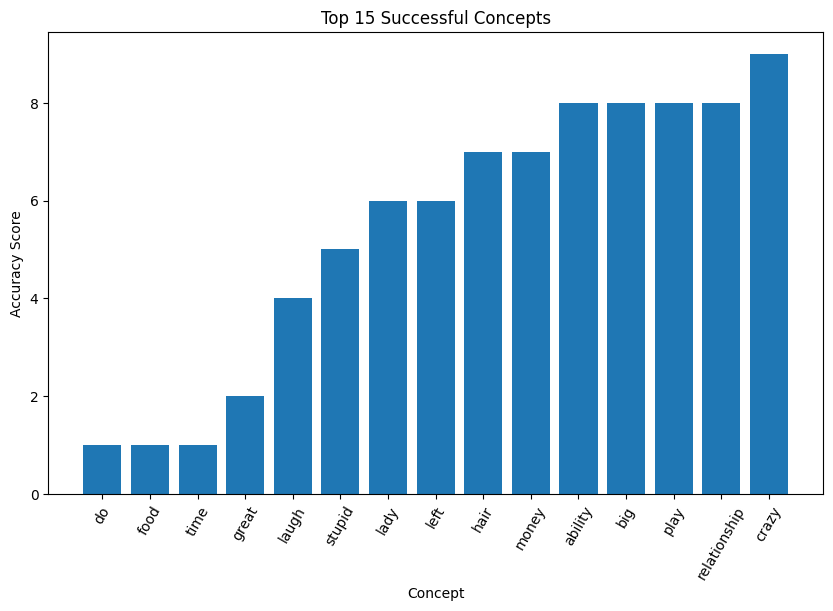

In [ ]:
#Top 15 successful concepts
import itertools

top_15 = dict(itertools.islice(successful_concepts.items(), 15))
x_axis =top_15.keys()
y_axis = top_15.values()
plt.figure(figsize=(10,6))
plt.bar(x_axis, y_axis)
x_tick = plt.xticks(rotation = 60)
plt.title("Top 15 Successful Concepts")
plt.xlabel("Concept")
plt.ylabel("Accuracy Score")
plt.plot()

Text(0, 0.5, 'Accuracy Score')

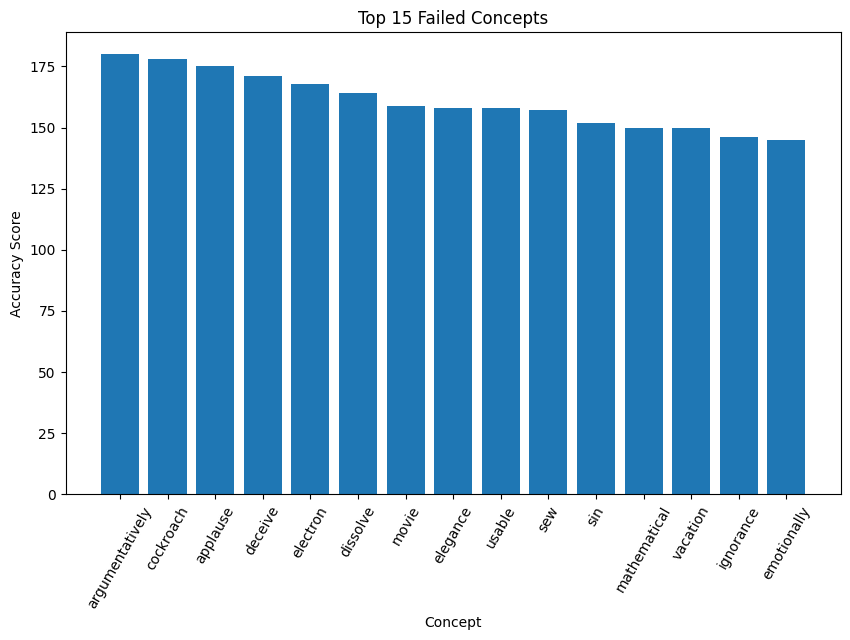

In [ ]:
#Top 15 failed concepts

top_15 = dict(itertools.islice(failed_concepts.items(), 15))
x_axis =top_15.keys()
y_axis = top_15.values()
plt.figure(figsize=(10,6))
plt.bar(x_axis, y_axis)
x_tick = plt.xticks(rotation = 60)
plt.title("Top 15 Failed Concepts")
plt.xlabel("Concept")
plt.ylabel("Accuracy Score")

### Are the results satisfactory, in your opinion? Why or why not?

\#TODO

# Export to PDF

Run the following cell to download the notebook as a nicely formatted pdf file.

In [ ]:
# Add to a new cell at the end of the notebook and run the follow code,
# which will save the notebook as pdf in your google drive (allow the permissions) and download it automatically.

!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py

from colab_pdf import colab_pdf

# If you saved the notebook in the default location in your Google Drive,
# and didn't change the name of the file, the code should work as is.
# If not, adapt accordingly.

colab_pdf(file_name='Copy of Pset_3.ipynb', notebookpath="/content/drive/MyDrive/Colab Notebooks/")

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=concepts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")